# U-Net segmentation test
## Dataset: http://data.celltrackingchallenge.net/training-datasets/DIC-C2DH-HeLa.zip

In [1]:
train_model = True
batch_size = 8
max_epochs = 180
checkpoint_dir = './models/HeLa/ckpt/'
save_path = './models/HeLa/model.keras'
load_path = './models/HeLa/model.keras'

## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc, os, cv2

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K

2024-11-02 10:53:05.344677: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 10:53:05.367436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730555585.383183  681549 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730555585.387828  681549 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 10:53:05.404251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
from unet.utils import UNetHelper
from unet.losses import IoU, dice_loss, unet_sample_weights
from unet.augmentation import elastic_deformation, grid_deformation

I0000 00:00:1730555588.822972  681549 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [5]:
import math
import warnings

lcm = lambda x, y: x * y // math.gcd(x, y)

### Set custom options

In [6]:
pd.pandas.set_option('display.max_columns', None)
#pd.pandas.set_option('display.max_rows', None)
#np.set_printoptions(threshold=sys.maxsize)

In [7]:
tf.get_logger().setLevel('ERROR')

## Strategy and Random Seed

In [8]:
reset_seed = lambda seed=42: tf.keras.utils.set_random_seed(seed)
reset_seed()

In [9]:
gpus = len(tf.config.list_physical_devices('GPU'))

if gpus <= 1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else: 
    strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
    
n_devices = strategy.num_replicas_in_sync
print(f'Using {n_devices} devices.')
print(f'Using {strategy.__class__.__name__}.')

Using 1 devices.
Using OneDeviceStrategy.


## Data Importation

In [ ]:
base_dir = 'DIC-C2DH-HeLa-Train{0}'

img_shape, img_mode = (512, 512, 1), cv2.IMREAD_UNCHANGED
mask_shape, mask_mode = (512, 512), cv2.IMREAD_UNCHANGED

# 84 training samples, 84 test samples.
data_len = 84 * 2
data_type = 'float32'

In [11]:
X = np.zeros((data_len, img_shape[0], img_shape[1], img_shape[2]), data_type)
y = np.zeros((data_len, mask_shape[0], mask_shape[1]), np.int32)
sample_weights = np.zeros((data_len, mask_shape[0], mask_shape[1]), data_type)

for i, (image_1, mask_1, image_2, mask_2) in enumerate(zip(os.listdir(base_dir.format("/01/")), 
                                                           os.listdir(base_dir.format("/01_ERR_SEG/")),
                                                           os.listdir(base_dir.format("/02/")),
                                                           os.listdir(base_dir.format("/02_ERR_SEG/")))):
    X[i] += np.expand_dims(cv2.imread(base_dir.format(f"/01/{image_1}"), img_mode), -1) / 255.
    X[i + data_len // 2] = np.expand_dims(cv2.imread(base_dir.format(f"/02/{image_2}"), img_mode), -1) / 255.

    y[i] += (cv2.imread(base_dir.format(f"/01_ERR_SEG/{mask_1}"), mask_mode) > 0) * 1
    y[i + data_len // 2] += (cv2.imread(base_dir.format(f"/02_ERR_SEG/{mask_2}"), mask_mode) > 0) * 1

    sample_weights[i] += unet_sample_weights(y[i], data_type=data_type)
    sample_weights[i + data_len // 2] += unet_sample_weights(y[i + data_len // 2], data_type=data_type)

#idx = np.arange(data_len)
#np.random.shuffle(idx)
#X, y, sample_weights = X[idx], y[idx], sample_weights[idx]
#del idx

gc.collect()
print('Done.')

Done.


## Data augmentation pipeline

In [12]:
@tf.function
def pipeline(X, y, w):
    y = tf.expand_dims(y, axis=-1)
    w = tf.expand_dims(w, axis=-1)
    # Horizontal flip.
    if tf.random.uniform((), 0., 1.) >= 0.5:
        X = tf.image.flip_left_right(X)
        y = tf.image.flip_left_right(y)
        w = tf.image.flip_left_right(w)
    # Vertical flip.
    if tf.random.uniform((), 0., 1.) >= 0.5:
        X = tf.image.flip_up_down(X)
        y = tf.image.flip_up_down(y)
        w = tf.image.flip_up_down(w)
    # Grid deformation.
    if tf.random.uniform((), 0., 1.) >= 0.5:
        grid_size = 5
        distort_limits = (-.35, .35)
        X = grid_deformation(X, distort_limits=distort_limits, grid_size=grid_size, order=1)
        y = grid_deformation(y, distort_limits=distort_limits, grid_size=grid_size, order=0)
        w = grid_deformation(w, distort_limits=distort_limits, grid_size=grid_size, order=0)
    # Elastic deformation
    #if tf.random.uniform((), 0., 1.) >= 0.:
    #    alpha = 100.
    #    sigma = 5.
    #    auto_kSize = True
    #    X = elastic_deformation(X, alpha=alpha, sigma=sigma, auto_kSize=auto_kSize, order=1)
    #    y = elastic_deformation(y, alpha=alpha, sigma=sigma, auto_kSize=auto_kSize, order=0)
    #    w = elastic_deformation(w, alpha=alpha, sigma=sigma, auto_kSize=auto_kSize, order=0)
    return [X, tf.squeeze(y), tf.squeeze(w)]

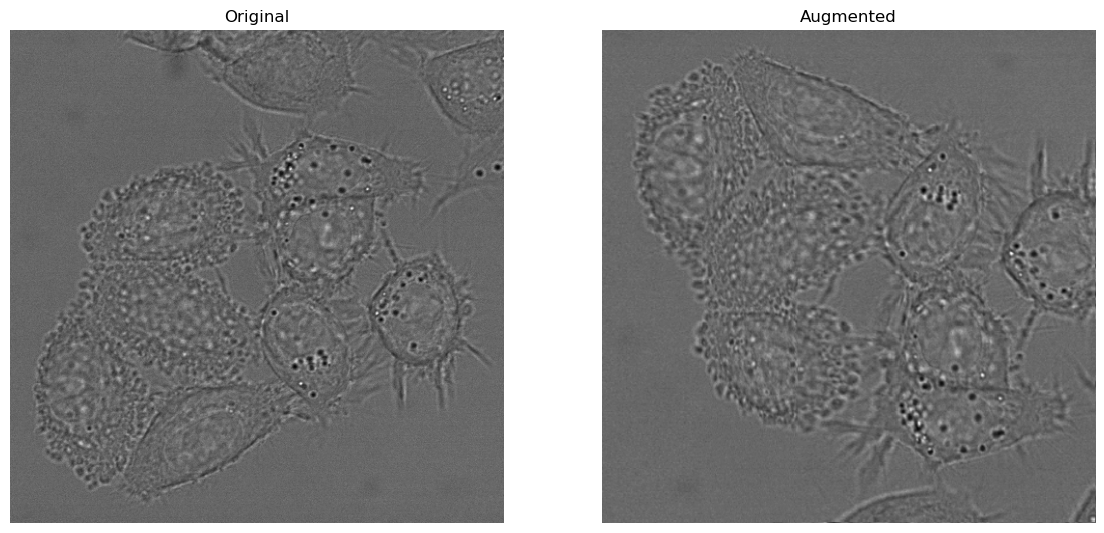

In [16]:
i = 0

reset_seed(420)
tmp = pipeline(X[i], y[i], sample_weights[i])

fig, ax = plt.subplots(1,2,figsize=(14,7))

ax[0].set_title("Original")
ax[0].imshow(X[i], cmap="gray")
ax[0].axis("off")
ax[1].set_title("Augmented")
ax[1].imshow(tmp[0], cmap="gray")
ax[1].axis("off")
plt.show()

## Create TF Datasets 

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((X[:data_len // 2], 
                                                y[:data_len // 2], 
                                                sample_weights[:data_len // 2]))

val_ds = tf.data.Dataset.from_tensor_slices((X[data_len // 2:], 
                                             y[data_len // 2:]))

train_ds = train_ds.map(pipeline, num_parallel_calls=tf.data.AUTOTUNE
                        ).shuffle(train_ds.cardinality(), reshuffle_each_iteration=True
                                  ).repeat(lcm(batch_size, data_len // 2) // (data_len // 2)).batch(batch_size, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE
                                                                                                    ).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(2 * batch_size, drop_remainder=False)

train_ds = strategy.experimental_distribute_dataset(train_ds)
val_ds = strategy.experimental_distribute_dataset(val_ds)
gc.collect()

15107

## Train model

In [19]:
def train(helper, train_dataset, val_dataset=None, epochs=100, ckpt_every=10, plot_every=1):
    history = []
    ds_card = train_dataset.cardinality
    for epoch in range(epochs):
        epoch += 1
        print(f'\nEpoch {epoch}/{epochs}')
            
        if helper.opt_schedule is not None: 
            helper.optimizer.learning_rate = helper.opt_schedule(epoch)
        progbar = tf.keras.utils.Progbar(target=ds_card)
        for i, batch in enumerate(train_dataset):
            i += 1
            loss, acc = helper.dist_train_step(batch)
            progbar.update(i, zip(['loss', 'acc'], [loss, acc]), finalize=False)

        if val_dataset is not None:
            val_loss, val_acc = 0.0, 0.0
            for j, batch in enumerate(val_dataset):
                vloss, vacc = helper.dist_val_step(batch)
                val_loss += vloss; val_acc += vacc
            val_loss /= (j+1); val_acc /= (j+1)
            history.append([loss, acc, val_loss, val_acc])
            progbar.update(i, zip(['loss', 'acc', 'val_loss', 'val_acc', 'lr'], 
                                [loss, acc, val_loss, val_acc, helper.optimizer.learning_rate.numpy()]), finalize=True)
        else: 
            history.append([loss, acc])
            progbar.update(i, zip(['loss', 'acc', 'lr'], [loss, acc, helper.optimizer.learning_rate.numpy()]), finalize=True)

        if type(ckpt_every) is int:
            if epoch % ckpt_every == 0: helper.checkpoint.save(helper.checkpoint_dir)
            
        if type(plot_every) is int:
            if epoch % plot_every == 0:
                plt.close()
                idx = np.random.choice(np.arange(data_len // 2, data_len, 1))
                image_list = [X[idx], y[idx], np.squeeze(helper.model(X[idx:idx+1], training=False).numpy().argmax(axis=-1))]
                image_list = [(255. * img).astype('uint8') if img.dtype!='uint8' else img for img in image_list]
                fig, ax = plt.subplots(1,3,figsize=(14,28))
                ax[0].set_title("Image")
                ax[1].set_title("Mask")
                ax[2].set_title("Predicted Mask")
                for k in range(3): 
                    ax[k].imshow(image_list[k], cmap="gray")
                    ax[k].axis('off')    
                plt.show()
    return history


Epoch 1/180


2024-11-02 11:20:40.474338: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
E0000 00:00:1730557247.065849  681549 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/u_net_1/spatial_dropout2d_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1730557247.977809  681733 cuda_dnn.cc:529] Loaded cuDNN version 90300


20/21 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.0207 - acc: 0.4886

2024-11-02 11:21:49.871617: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-11-02 11:21:49.871931: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.0128 - acc: 0.4893

2024-11-02 11:22:14.859201: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - loss: 1.0055 - acc: 0.4899 - val_loss: 0.7070 - val_acc: 0.5045 - lr: 0.0010

Epoch 2/180
20/21 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.8712 - acc: 0.5119

2024-11-02 11:22:49.401736: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.8745 - acc: 0.5126 - val_loss: 0.7088 - val_acc: 0.4763 - lr: 0.0010

Epoch 3/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.8038 - acc: 0.5286 - val_loss: 0.7076 - val_acc: 0.4731 - lr: 0.0010


2024-11-02 11:23:29.675910: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 4/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.7677 - acc: 0.5629 - val_loss: 0.7014 - val_acc: 0.4717 - lr: 0.0010

Epoch 5/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.7420 - acc: 0.5928 - val_loss: 0.7054 - val_acc: 0.4710 - lr: 0.0010

Epoch 6/180
20/21 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.7304 - acc: 0.6136

2024-11-02 11:24:58.958645: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.7260 - acc: 0.6144 - val_loss: 0.7131 - val_acc: 0.4705 - lr: 0.0010

Epoch 7/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.7001 - acc: 0.6306 - val_loss: 0.7229 - val_acc: 0.4702 - lr: 0.0010

Epoch 8/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.6789 - acc: 0.6443 - val_loss: 0.7342 - val_acc: 0.4699 - lr: 0.0010

Epoch 9/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.6811 - acc: 0.6544 - val_loss: 0.7461 - val_acc: 0.4697 - lr: 0.0010

Epoch 10/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.6528 - acc: 0.6642 - val_loss: 0.7597 - val_acc: 0.4696 - lr: 0.0010

Epoch 11/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.6333 - acc: 0.6727 - val_loss: 0.7740 - val_acc: 0.4695 - lr: 0.0010


2024-11-02 11:27:54.155609: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 12/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.6359 - acc: 0.6805 - val_loss: 0.7882 - val_acc: 0.4694 - lr: 0.0010

Epoch 13/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.6189 - acc: 0.6870 - val_loss: 0.8010 - val_acc: 0.4694 - lr: 0.0010

Epoch 14/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.6115 - acc: 0.6930 - val_loss: 0.8099 - val_acc: 0.4692 - lr: 0.0010

Epoch 15/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.6136 - acc: 0.6981 - val_loss: 0.8140 - val_acc: 0.4693 - lr: 0.0010

Epoch 16/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.6087 - acc: 0.7024 - val_loss: 0.8105 - val_acc: 0.4698 - lr: 0.0010

Epoch 17/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.5803 - acc: 0.7071 - val_loss: 0.7967 - val_acc: 0.4712 - lr: 0.0010

Epoch 18/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.5933 - acc: 0.7112 - val_loss: 0.7750 - val_acc: 0.4737 - lr: 0.0010

Epoch 19/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.5586 - acc: 0

2024-11-02 11:32:11.374150: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.5577 - acc: 0.7265 - val_loss: 0.5386 - val_acc: 0.5033 - lr: 0.0010

Epoch 23/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.5360 - acc: 0.7294 - val_loss: 0.4962 - val_acc: 0.5150 - lr: 0.0010

Epoch 24/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.5333 - acc: 0.7328 - val_loss: 0.4329 - val_acc: 0.5272 - lr: 0.0010

Epoch 25/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.5464 - acc: 0.7356 - val_loss: 0.4127 - val_acc: 0.5393 - lr: 0.0010

Epoch 26/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.5199 - acc: 0.7384 - val_loss: 0.4079 - val_acc: 0.5508 - lr: 0.0010

Epoch 27/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.4987 - acc: 0.7414 - val_loss: 0.3895 - val_acc: 0.5616 - lr: 0.0010

Epoch 28/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4902 - acc: 0.7444 - val_loss: 0.3816 - val_acc: 0.5718 - lr: 0.0010

Epoch 29/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.5072 - acc: 0.7470 - val_lo

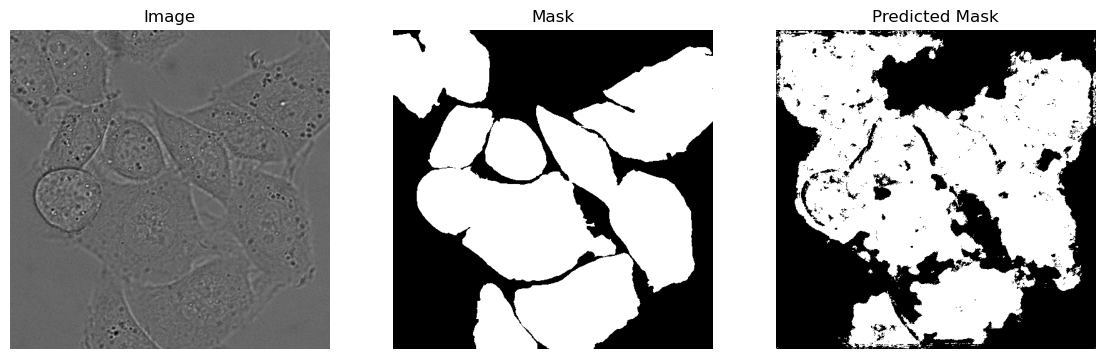


Epoch 31/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4598 - acc: 0.7525 - val_loss: 0.3596 - val_acc: 0.5987 - lr: 0.0010

Epoch 32/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4789 - acc: 0.7551 - val_loss: 0.3571 - val_acc: 0.6067 - lr: 0.0010

Epoch 33/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4568 - acc: 0.7578 - val_loss: 0.3537 - val_acc: 0.6143 - lr: 0.0010

Epoch 34/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4626 - acc: 0.7604 - val_loss: 0.3535 - val_acc: 0.6215 - lr: 0.0010

Epoch 35/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.4833 - acc: 0.7627 - val_loss: 0.3816 - val_acc: 0.6281 - lr: 0.0010

Epoch 36/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.4467 - acc: 0.7649 - val_loss: 0.3799 - val_acc: 0.6341 - lr: 0.0010

Epoch 37/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4519 - acc: 0.7672 - val_loss: 0.3460 - val_acc: 0.6401 - lr: 0.0010

Epoch 38/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.3939 - acc: 0

2024-11-02 11:40:24.300875: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 44/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4196 - acc: 0.7811 - val_loss: 0.3193 - val_acc: 0.6762 - lr: 0.0010

Epoch 45/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4194 - acc: 0.7829 - val_loss: 0.3116 - val_acc: 0.6807 - lr: 0.0010

Epoch 46/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3663 - acc: 0.7849 - val_loss: 0.2912 - val_acc: 0.6850 - lr: 0.0010

Epoch 47/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4216 - acc: 0.7867 - val_loss: 0.3135 - val_acc: 0.6892 - lr: 0.0010

Epoch 48/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4077 - acc: 0.7883 - val_loss: 0.3030 - val_acc: 0.6931 - lr: 0.0010

Epoch 49/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4007 - acc: 0.7900 - val_loss: 0.2803 - val_acc: 0.6971 - lr: 0.0010

Epoch 50/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.4005 - acc: 0.7915 - val_loss: 0.2927 - val_acc: 0.7010 - lr: 0.0010

Epoch 51/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.4383 - acc: 0

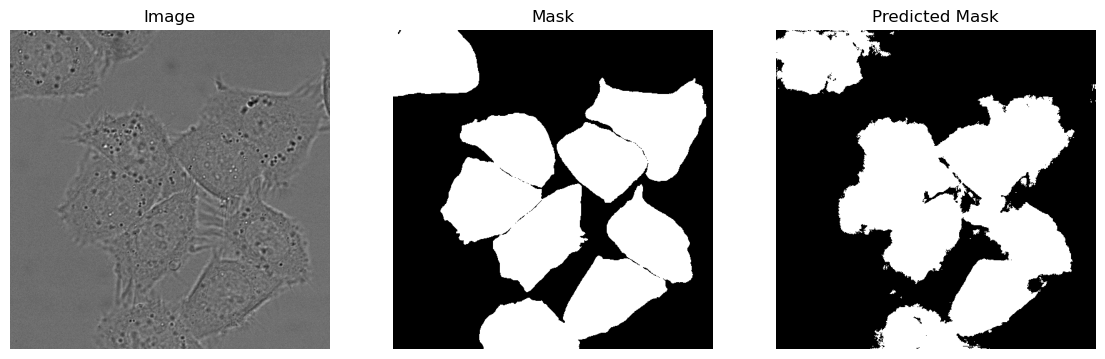


Epoch 61/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 993ms/step - loss: 0.3879 - acc: 0.8054 - val_loss: 0.3417 - val_acc: 0.7349 - lr: 0.0010

Epoch 62/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.4208 - acc: 0.8063 - val_loss: 0.3573 - val_acc: 0.7370 - lr: 0.0010

Epoch 63/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3906 - acc: 0.8072 - val_loss: 0.3425 - val_acc: 0.7389 - lr: 0.0010

Epoch 64/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.4065 - acc: 0.8080 - val_loss: 0.3532 - val_acc: 0.7407 - lr: 0.0010

Epoch 65/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3836 - acc: 0.8090 - val_loss: 0.3769 - val_acc: 0.7424 - lr: 0.0010

Epoch 66/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.3935 - acc: 0.8098 - val_loss: 0.3645 - val_acc: 0.7440 - lr: 0.0010

Epoch 67/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.4134 - acc: 0.8106 - val_loss: 0.4283 - val_acc: 0.7454 - lr: 0.0010

Epoch 68/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3860 - acc

2024-11-02 11:57:05.311168: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.3771 - acc: 0.8245 - val_loss: 0.2495 - val_acc: 0.7742 - lr: 0.0010

Epoch 87/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.4072 - acc: 0.8249 - val_loss: 0.3647 - val_acc: 0.7754 - lr: 0.0010

Epoch 88/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.3680 - acc: 0.8254 - val_loss: 0.4659 - val_acc: 0.7762 - lr: 0.0010

Epoch 89/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.3703 - acc: 0.8259 - val_loss: 0.4048 - val_acc: 0.7770 - lr: 0.0010

Epoch 90/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.3527 - acc: 0.8264 - val_loss: 0.5100 - val_acc: 0.7778 - lr: 0.0010


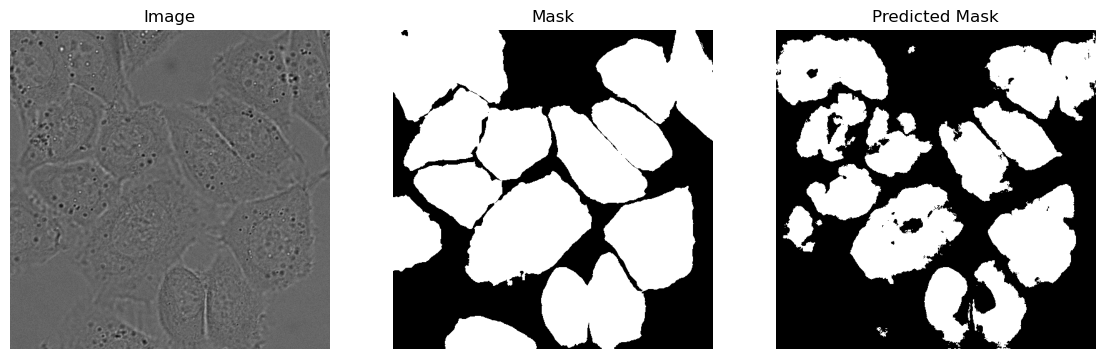


Epoch 91/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3887 - acc: 0.8269 - val_loss: 0.4358 - val_acc: 0.7786 - lr: 0.0010

Epoch 92/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3982 - acc: 0.8272 - val_loss: 0.6801 - val_acc: 0.7794 - lr: 0.0010

Epoch 93/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3574 - acc: 0.8276 - val_loss: 0.4155 - val_acc: 0.7803 - lr: 0.0010

Epoch 94/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.3477 - acc: 0.8283 - val_loss: 0.3589 - val_acc: 0.7814 - lr: 0.0010

Epoch 95/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.3691 - acc: 0.8288 - val_loss: 0.2767 - val_acc: 0.7826 - lr: 0.0010

Epoch 96/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3289 - acc: 0.8294 - val_loss: 0.2968 - val_acc: 0.7839 - lr: 0.0010

Epoch 97/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3444 - acc: 0.8300 - val_loss: 0.4830 - val_acc: 0.7850 - lr: 0.0010

Epoch 98/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3500 - acc: 0

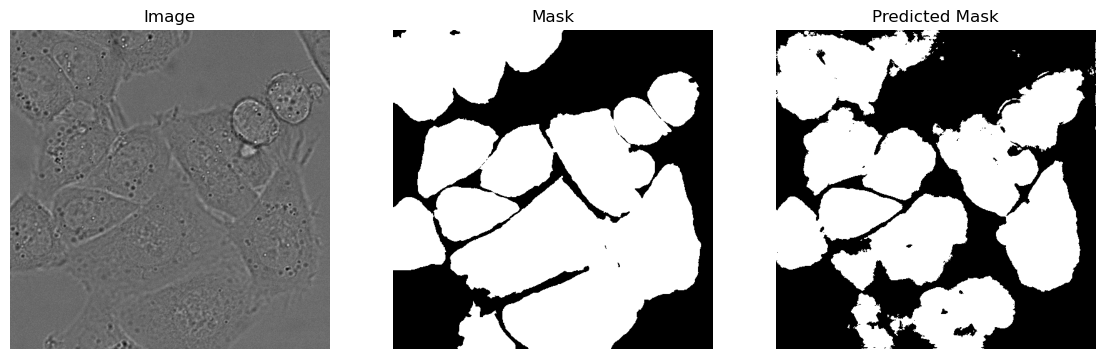


Epoch 121/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 940ms/step - loss: 0.3029 - acc: 0.8408 - val_loss: 0.2203 - val_acc: 0.8061 - lr: 0.0010

Epoch 122/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 943ms/step - loss: 0.3314 - acc: 0.8413 - val_loss: 0.2784 - val_acc: 0.8069 - lr: 0.0010

Epoch 123/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 946ms/step - loss: 0.3584 - acc: 0.8416 - val_loss: 0.3341 - val_acc: 0.8076 - lr: 0.0010

Epoch 124/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 944ms/step - loss: 0.3600 - acc: 0.8419 - val_loss: 0.4847 - val_acc: 0.8081 - lr: 0.0010

Epoch 125/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 972ms/step - loss: 0.3363 - acc: 0.8422 - val_loss: 0.6090 - val_acc: 0.8087 - lr: 0.0010

Epoch 126/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 949ms/step - loss: 0.3779 - acc: 0.8424 - val_loss: 0.2815 - val_acc: 0.8094 - lr: 0.0010

Epoch 127/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 969ms/step - loss: 0.3667 - acc: 0.8426 - val_loss: 0.2648 - val_acc: 0.8102 - lr: 0.0010

Epoch 128/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 99

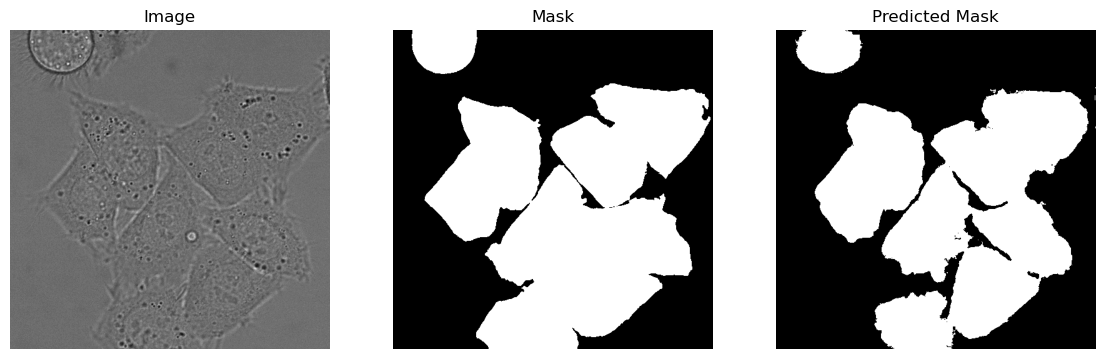


Epoch 151/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 952ms/step - loss: 0.3496 - acc: 0.8496 - val_loss: 0.3040 - val_acc: 0.8228 - lr: 0.0010

Epoch 152/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 949ms/step - loss: 0.3497 - acc: 0.8498 - val_loss: 0.4082 - val_acc: 0.8232 - lr: 0.0010

Epoch 153/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 985ms/step - loss: 0.3469 - acc: 0.8499 - val_loss: 0.3467 - val_acc: 0.8236 - lr: 0.0010

Epoch 154/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.3574 - acc: 0.8501 - val_loss: 0.4694 - val_acc: 0.8240 - lr: 0.0010

Epoch 155/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 957ms/step - loss: 0.3302 - acc: 0.8503 - val_loss: 0.4580 - val_acc: 0.8244 - lr: 0.0010

Epoch 156/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 950ms/step - loss: 0.3241 - acc: 0.8505 - val_loss: 0.3167 - val_acc: 0.8248 - lr: 0.0010

Epoch 157/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 958ms/step - loss: 0.3356 - acc: 0.8507 - val_loss: 0.4596 - val_acc: 0.8250 - lr: 0.0010

Epoch 158/180
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 965ms

2024-11-02 12:29:14.597010: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 172/180
18/21 ━━━━━━━━━━━━━━━━━━━━ 2s 860ms/step - loss: 0.3267 - acc: 0.8543

In [ ]:
#max_lr = 1.E-2
max_lr = 1.E-3
lr_decay_start, lr_decay_rate, lr_decay_step = (2, 0.1, 3)
model_param = {"input_shape": img_shape,
               "dropout": 0.2,
               }

try:
    del helper
except:
    pass

reset_seed()
K.clear_session()

with strategy.scope():    
    gc.collect()
    
    helper = UNetHelper(strategy=strategy,
                        model_param=model_param,
                        loss_func=tf.keras.losses.sparse_categorical_crossentropy,
                        optimizer=tf.keras.optimizers.SGD(learning_rate=max_lr, momentum=0.99),
                        #opt_schedule=tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[5,], values=[1e-2, 1e-3]),
                        )
    
    if train_model:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            train(helper, train_ds, val_ds, max_epochs, ckpt_every=15, plot_every=30)
        helper.model.save(save_path)
    else: helper.model.load(load_path)

## Check predictions

In [98]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pred = helper.model.predict(X[data_len // 2:])

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step 


In [99]:
# np.round wasn't working properly so I had to add a fuzz factor before rounding the results lol.
print(f"Average IoU on holdout set: {np.round(IoU(y[data_len // 2:], pred).numpy().mean() + 1E-10, 4)}")
print(f"Average Dice loss on holdout set: {np.round(dice_loss(y[data_len // 2:], pred).numpy().mean() + 1E-10, 4)}")

Average IoU on holdout set: 0.8839
Average Dice loss on holdout set: 0.0712


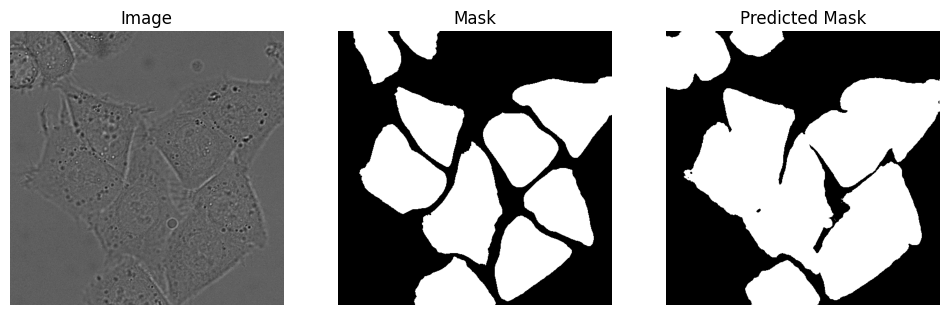

In [110]:
j = 5

fig, ax = plt.subplots(1, 3, figsize=(12, 36))
subtitles = ['Image', 'Mask', 'Predicted Mask']
image_list = [X[data_len // 2:][j], y[data_len // 2:][j], np.squeeze(pred[j].argmax(axis=-1))]
for i in range(3):
    ax[i].imshow(image_list[i], cmap="gray")
    ax[i].set_title(subtitles[i])              
    ax[i].axis('off')
plt.show()

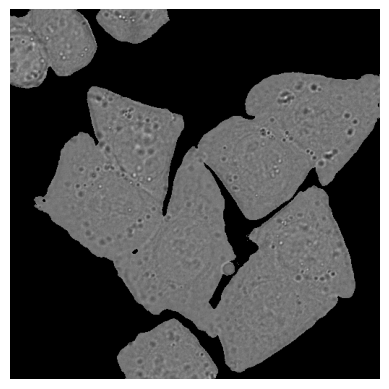

In [119]:
plt.imshow(np.multiply(image_list[0], np.expand_dims(image_list[-1], axis=-1)), cmap="gray")
plt.axis('off')
plt.show()